In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.text import *
from fastai.imports import *
from fastai2.text.all import *

from utils import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = None


In [2]:
base_path="../output"
text_columns=['text']
label_columns=['target']
BATCH_SIZE=128

In [3]:
path = Path()
path.ls()

(#8) [Path('.ipynb_checkpoints'),Path('models'),Path('sample_submission.csv'),Path('submission1_nar_tweetDisaster.csv'),Path('test.csv'),Path('train.csv'),Path('tweetDisaster.html'),Path('tweetDisaster.ipynb')]

In [4]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
print(f'The training set has {len(train)} records.')
print(f'The test set has {len(test)} records.')

The training set has 7613 records.
The test set has 3263 records.


In [6]:
# Tokenization

In [7]:
txts = L([i for i in train['text']])

In [8]:
# Setting up a tokenizer on the entire dataframe 'train'
tok = Tokenizer.from_df(train)
tok.setup(train)

toks = txts.map(tok)
toks[0]

(#21) ['xxbos','xxmaj','our','xxmaj','deeds','are','the','xxmaj','reason','of'...]

In [9]:
# Numericalization

In [10]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num)
nums[0][:10]

tensor([  2,   8, 150,   8,   0,  43,  14,   8, 884,  19])

In [11]:
# Creating a dataloader¶

In [12]:
# dataset for fine-tuning language model which only needs the text data

df_lm = pd.concat([train, test], axis=0)[['text']]
df_lm.head()

,text
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,"13,000 people receive #wildfires evacuation orders in California"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [13]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(0.1) 
    # using only 10% of entire comments data for validation inorder to learn more
)

In [14]:
dls_lm = dls_lm.dataloaders(df_lm, bs=64, seq_len=72)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
dls_lm.show_batch(max_n=3)

,text,text_
0,xxbos xxmaj the xxmaj murderous xxmaj story xxmaj of xxmaj americaûªs xxmaj first xxmaj hijacking http : / / t.co / xxunk xxbos xxunk xxmaj xxunk ideas . xxmaj i 'm xxunk xxunk hard now have almost nothing fear lives with poor \n xxmaj fran xxmaj xxunk xxunk xxbos xxmaj do you feel engulfed with low self - image ? xxmaj take the quiz : http : / / t.co / xxunk,xxmaj the xxmaj murderous xxmaj story xxmaj of xxmaj americaûªs xxmaj first xxmaj hijacking http : / / t.co / xxunk xxbos xxunk xxmaj xxunk ideas . xxmaj i 'm xxunk xxunk hard now have almost nothing fear lives with poor \n xxmaj fran xxmaj xxunk xxunk xxbos xxmaj do you feel engulfed with low self - image ? xxmaj take the quiz : http : / / t.co / xxunk http
1,/ / t.co / xxunk t xxbos xxup mp train derailment : xxmaj village youth saved many lives \n http : / / t.co / xxunk # xxunk http : / / t.co / xxunk xxbos xxmaj keep alive your sound intensity level xxunk in keeping with xxunk effect casualty insurance : xxunk xxbos xxmaj skinny xxmaj jeans are xxmaj hazardous for xxmaj your xxmaj health ! # socialnews http : /,/ t.co / xxunk t xxbos xxup mp train derailment : xxmaj village youth saved many lives \n http : / / t.co / xxunk # xxunk http : / / t.co / xxunk xxbos xxmaj keep alive your sound intensity level xxunk in keeping with xxunk effect casualty insurance : xxunk xxbos xxmaj skinny xxmaj jeans are xxmaj hazardous for xxmaj your xxmaj health ! # socialnews http : / /
2,xxmaj officer xxmaj wounded xxmaj suspect xxmaj dead xxmaj after xxmaj exchanging xxmaj shots . xxmaj more # news - http : / / t.co / xxunk xxbos xxmaj whoever got xxunk with xxmaj hazard xxunk away one by one . \n xxmaj xxunk \n xxmaj xxunk \n xxmaj di xxmaj maria \n xxmaj who 's next ? xxbos xxunk xxmaj xxunk theater shooting trial : xxmaj gunman expected xxunk for mass,officer xxmaj wounded xxmaj suspect xxmaj dead xxmaj after xxmaj exchanging xxmaj shots . xxmaj more # news - http : / / t.co / xxunk xxbos xxmaj whoever got xxunk with xxmaj hazard xxunk away one by one . \n xxmaj xxunk \n xxmaj xxunk \n xxmaj di xxmaj maria \n xxmaj who 's next ? xxbos xxunk xxmaj xxunk theater shooting trial : xxmaj gunman expected xxunk for mass murder


In [16]:
#fine-tuning wikitext LM to disaster tweets dataset

In [17]:
learn = language_model_learner(
    dls_lm, AWD_LSTM,
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.04786301031708717)

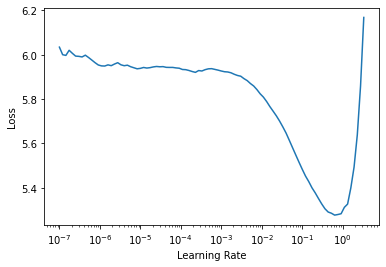

In [18]:
learn.lr_find()

In [19]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.973695,3.746660,0.371695,42.379276,00:13


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.892231,3.434197,0.405444,31.006502,00:15
1,3.617866,3.211069,0.436303,24.805586,00:15
2,3.389146,3.106172,0.449200,22.335382,00:15
3,3.233072,3.061495,0.455413,21.359472,00:15
4,3.123642,3.054050,0.457230,21.201035,00:15


In [20]:
# Saving the encoder

learn.save_encoder('finetuned')

In [21]:
# Creating the classifier dataloader

In [22]:
blocks = (TextBlock.from_df('text', seq_len=dls_lm.seq_len, vocab=dls_lm.vocab), CategoryBlock())
dls = DataBlock(blocks=blocks,
                get_x=ColReader('text'),
                get_y=ColReader('target'),
                splitter=RandomSplitter(0.2))

In [23]:
dls = dls.dataloaders(train, bs=64)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [24]:
dls.show_batch(max_n=3)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1
2,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0


In [25]:
len(dls.train_ds), len(dls.valid_ds)

(6091, 1522)

In [26]:
# Defining the learner

In [27]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy, FBeta(beta=1)]).to_fp16()
learn.load_encoder('finetuned')

In [28]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.584937,0.421352,0.816689,0.768465,00:04


In [29]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.505742,0.419490,0.815374,0.777514,00:05


In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),3e-3))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.440513,0.426962,0.809461,0.768740,00:07
1,0.413033,0.428290,0.810775,0.780488,00:07


In [31]:
# submission

In [32]:
sub = pd.read_csv(path/'sample_submission.csv')
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [33]:
dl = learn.dls.test_dl(test['text'])

In [34]:
preds = learn.get_preds(dl=dl)

In [35]:
sub['target'] = preds[0].argmax(dim=-1)

In [36]:
# sub.to_csv('submission1_nar_tweetDisaster.csv', index=False)
sub.head()
# score 0.81213

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
